# 03 Сеть для одного голосования
### UKRAINE--POLITICAL CONDITIONS

In [69]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx

from numpy.random import default_rng
rng = default_rng()

## 1. Читаем общую таблицу по голосованиям с диска

In [15]:
votes_table_com = pd.read_csv('votes_table.csv')
votes_table_com

,Data,Resolution,Title,Uri,Tags,Topic
0,2022-11-14,A/RES/ES-11/5,Furtherance of remedy and reparation for aggre...,https://digitallibrary.un.org/record/3994052,"['russia', 'ukraine', 'war']",['UKRAINE--POLITICAL CONDITIONS']
1,2022-10-12,A/RES/ES-11/4,Territorial integrity of Ukraine : defending t...,https://digitallibrary.un.org/record/3990400,"['russia', 'ukraine', 'war']",['UKRAINE--POLITICAL CONDITIONS']
2,2022-04-07,A/RES/ES-11/3,Suspension of the rights of membership of the ...,https://digitallibrary.un.org/record/3967778,"['russia', 'ukraine', 'war']",['UKRAINE--POLITICAL CONDITIONS']
3,2022-03-24,A/RES/ES-11/2,Humanitarian consequences of the aggression ag...,https://digitallibrary.un.org/record/3965954,"['russia', 'ukraine', 'war']",['UKRAINE--POLITICAL CONDITIONS']
4,2022-03-02,A/RES/ES-11/1,Aggression against Ukraine : resolution / adop...,https://digitallibrary.un.org/record/3959039,"['russia', 'ukraine', 'war']",['UKRAINE--POLITICAL CONDITIONS']


## 2. Data processing

In [1565]:
# редактирование таблицы
# votes_table_com.drop([0, 1])

## 3. Net making

In [88]:
resolution_index = 4

In [89]:
# Читаем таблицу голосования по индексу в votes_table_com
common_table = pd.read_csv(
    'resolution_vote/' + votes_table_com['Resolution'][resolution_index]
    .replace('/', '_') + '.csv', 
    index_col=['Country']
)
common_table

,A/RES/ES-11/1
Country,
AFGHANISTAN,1.0
ALBANIA,1.0
ALGERIA,0.0
ANDORRA,1.0
ANGOLA,0.0
...,...
VENEZUELA (BOLIVARIAN REPUBLIC OF),NaN
VIET NAM,0.0
YEMEN,1.0


In [90]:
common_table.head()

,A/RES/ES-11/1
Country,
AFGHANISTAN,1.0
ALBANIA,1.0
ALGERIA,0.0
ANDORRA,1.0
ANGOLA,0.0


In [91]:
len(common_table.index)

193

### 3.2 Убираем разное написание Турции

In [92]:
common_table[common_table.index == 'TURKEY']

,A/RES/ES-11/1
Country,
TURKEY,1.0


In [93]:
common_table[common_table.index == 'TURKIYE']

,A/RES/ES-11/1
Country,


In [94]:
common_table[common_table.index == 'TÜRKIYE']

,A/RES/ES-11/1
Country,


In [85]:
#list(common_table[(common_table.index == 'TURKEY') + (common_table.index == 'TURKIYE') + (common_table.index == 'TÜRKIYE')].sum())

In [98]:
common_table.loc['TURKIYE'] = common_table.loc[['TURKEY'], list(common_table.columns)].sum()
common_table.drop(['TURKEY'], inplace = True)

In [99]:
common_table.loc[["TURKIYE"], list(common_table.columns)]

,A/RES/ES-11/1
Country,
TURKIYE,1.0


### 3.3 Простая сети по одому голосованию 

In [100]:
# принимает таблицу с рещультатами голосования common_table
# возвращает два массива c парной узлов (ребром)

def get_edges(table):
    nodes_1 = []
    nodes_2 = []
    count_index = len(common_table.index)
    
    for index_first in range(0, count_index-1):
        for index_second in range(index_first+1, count_index):

            nodes_1.append(table.index[index_first])
            nodes_2.append(table.index[index_second])
        
    return [nodes_1, nodes_2]

In [101]:
# принимает таблицу с результатами голосования из common_table и название расчетного столбца голосования 
# возвращает массив оценки солидарности шголосования solid_val

def get_solid_val(table, item):
    solid_val = []
    count_index = len(table.index)
    
    for index_first in range(0, count_index-1):
        for index_second in range(index_first+1, count_index):
            
            # сравнение индексов голосования
            if (pd.isnull(table.iloc[index_first][item]) or pd.isnull(table.iloc[index_second][item])): 
                solid_val.append(np.nan) 
            else: 
                # Это значит, что если оба воздержались, то 0 == 0 это True
                solid_val.append(table.iloc[index_first][item] == table.iloc[index_second][item])
                # Нужно ли давать 1 если 1 == 1, -1 если -1 == -1... как быть с 0?
            
    return solid_val

In [102]:
#
# ЗАГРУЗНЫЙ ПРЦЕСС !!!!!
#
# создаем таблицу ребер сети

net_table = pd.DataFrame()

# создаем все ребра сети
nodes_arr = get_edges(common_table)
net_table['Nodes_1'] = nodes_arr[0]
net_table['Nodes_2'] = nodes_arr[1]

# заполняем результаты голосований
for item in common_table.columns: 
    net_table[item] = get_solid_val(common_table, item)

net_table

,Nodes_1,Nodes_2,A/RES/ES-11/1
0,AFGHANISTAN,ALBANIA,True
1,AFGHANISTAN,ALGERIA,False
2,AFGHANISTAN,ANDORRA,True
3,AFGHANISTAN,ANGOLA,False
4,AFGHANISTAN,ANTIGUA AND BARBUDA,True
...,...,...,...
18523,YEMEN,ZIMBABWE,False
18524,YEMEN,TURKIYE,True
18525,ZAMBIA,ZIMBABWE,False
18526,ZAMBIA,TURKIYE,True


In [103]:
net_table_one_vote = pd.DataFrame(net_table)
net_table_one_vote

,Nodes_1,Nodes_2,A/RES/ES-11/1
0,AFGHANISTAN,ALBANIA,True
1,AFGHANISTAN,ALGERIA,False
2,AFGHANISTAN,ANDORRA,True
3,AFGHANISTAN,ANGOLA,False
4,AFGHANISTAN,ANTIGUA AND BARBUDA,True
...,...,...,...
18523,YEMEN,ZIMBABWE,False
18524,YEMEN,TURKIYE,True
18525,ZAMBIA,ZIMBABWE,False
18526,ZAMBIA,TURKIYE,True


In [104]:
list(net_table_one_vote.columns)

['Nodes_1', 'Nodes_2', 'A/RES/ES-11/1']

### Net building

In [105]:
from numpy.random import default_rng
rng = default_rng()

In [106]:
net_table_one_vote_weight = net_table_one_vote.replace({True: 1, False: 0})
#net_table_weight = net_table

# Коцаем табличку
#net_table_one_vote_weight.drop([net_table_one_vote_weight.index[x] for x in rng.choice(19109, size=18400, replace=False)], inplace=True)

#net_table_one_vote_weight['A/RES/ES-11/5'] = abs(net_table_one_vote_weight[list(net_table_one_vote_weight.columns)[2:]].sum(axis=1))
#net_table_weight.drop(list(net_table_weight.columns)[2:-1], inplace=True, axis=1)

net_table_one_vote_weight = net_table_one_vote_weight[net_table_one_vote_weight[votes_table_com['Resolution'][resolution_index]] != 0]
#net_table_weight = net_table_weight[net_table_weight.Solid_val > 5]
net_table_one_vote_weight.dropna(inplace = True)

net_table_one_vote_weight

,Nodes_1,Nodes_2,A/RES/ES-11/1
0,AFGHANISTAN,ALBANIA,1.0
2,AFGHANISTAN,ANDORRA,1.0
4,AFGHANISTAN,ANTIGUA AND BARBUDA,1.0
5,AFGHANISTAN,ARGENTINA,1.0
7,AFGHANISTAN,AUSTRALIA,1.0
...,...,...,...
18512,VANUATU,TURKIYE,1.0
18520,VIET NAM,ZIMBABWE,1.0
18522,YEMEN,ZAMBIA,1.0
18524,YEMEN,TURKIYE,1.0


In [107]:
G_one_vote = nx.Graph()
#G_one_vote.add_nodes_from(list(net_table_weight_val.index))
#net_table_one_vote_weight[0:1000].apply(lambda x: G_one_vote.add_edge(x[0], x[1], weight= x[2]), axis=1)
net_table_one_vote_weight.apply(lambda x: G_one_vote.add_edge(x[0], x[1], weight= x[2]), axis=1)

0        None
2        None
4        None
5        None
7        None
         ... 
18512    None
18520    None
18522    None
18524    None
18526    None
Length: 10475, dtype: object

In [108]:
#nx.number_connected_components(G)
#len(sorted(nx.connected_components(G)))


#country_arr_test = list(nx.connected_components(G_one_vote))[2]

In [109]:
len(G_one_vote.nodes())

181

In [110]:
len(G_one_vote.edges())

10475

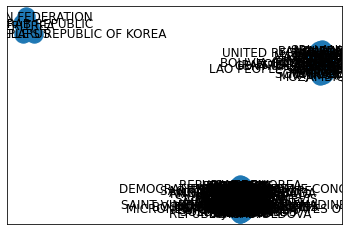

In [111]:
#figure(figsize=(20, 10))

nx.draw_networkx(G_one_vote)

In [112]:
nx.is_connected(G_one_vote)

False

In [113]:
nx.number_connected_components(G_one_vote)

3

In [115]:
country_name = 'RUSSIAN FEDERATION'
#country_name = 'LESOTHO'
#country_name = 'NICARAGUA'

for index in range (0, len(list(nx.connected_components(G_one_vote)))):
    print('')
    print(index)
    
    if country_name in list(nx.connected_components(G_one_vote))[index]: print('True')
    else: print('False')
        
    print('')
    
    country_arr_test = list(nx.connected_components(G_one_vote))[index]
    print(country_arr_test)
    print('______________')


0
False

{'COLOMBIA', 'TUNISIA', 'OMAN', 'MONACO', 'UNITED ARAB EMIRATES', 'MALTA', 'KIRIBATI', 'GEORGIA', 'SLOVENIA', 'SWITZERLAND', 'ZAMBIA', 'FRANCE', 'REPUBLIC OF MOLDOVA', 'SAN MARINO', 'ECUADOR', 'PARAGUAY', 'KUWAIT', 'NAURU', 'CHAD', 'ITALY', 'BRUNEI DARUSSALAM', 'LATVIA', 'LESOTHO', 'BULGARIA', 'MALAWI', 'NORWAY', 'GRENADA', 'AUSTRIA', 'SAO TOME AND PRINCIPE', 'KENYA', 'ISRAEL', 'GUATEMALA', 'MONTENEGRO', 'MAURITIUS', 'DJIBOUTI', 'SINGAPORE', 'BENIN', 'PALAU', 'BAHRAIN', 'NIGERIA', 'MALAYSIA', 'SERBIA', 'GABON', 'YEMEN', 'MICRONESIA (FEDERATED STATES OF)', 'TURKIYE', 'ALBANIA', 'COMOROS', 'GERMANY', 'BARBADOS', 'SOMALIA', 'NETHERLANDS', 'BHUTAN', 'ESTONIA', 'LIECHTENSTEIN', 'JAPAN', 'NIGER', 'SAINT KITTS AND NEVIS', 'DOMINICA', 'HONDURAS', 'MYANMAR', 'PAPUA NEW GUINEA', 'SPAIN', 'ROMANIA', 'QATAR', 'NEW ZEALAND', 'PANAMA', 'BAHAMAS', 'LIBERIA', 'CAMBODIA', 'LITHUANIA', 'DEMOCRATIC REPUBLIC OF THE CONGO', 'GREECE', 'VANUATU', 'UNITED KINGDOM', 'HAITI', "CÔTE D'IVOIRE", 'REPUBLI

In [116]:
common_table[common_table.index == 'ERITREA']

,A/RES/ES-11/1
Country,
ERITREA,-1.0
